In [1]:
# Python Libraries
import numpy as np
from numpy import linalg
import matplotlib
import matplotlib.pyplot as plt
import scipy
from IPython.display import display, Math, Latex

from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli, SuperOp
from qiskit.quantum_info import process_fidelity, DensityMatrix, partial_trace
from qiskit.circuit import Parameter

from qiskit import execute, Aer, IBMQ
from qiskit.providers.ibmq import IBMQFactory,least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise

print('Import successfull')

Import successfull


# Local Depolarization, fragment $\mathcal{F}=\mathcal{E}_1$

In [2]:
#Setting the number of shots
Nshots = 12000

#Creating a list of possible measurement outcomes for 5 bits
n = 5
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(6) #1 system qubit, 4 environment qubits, ancilla qubit for nondestructive parity check
cr = ClassicalRegister(n)

#Creating list of strengths of depolarizing channel
ps = np.linspace(0,1,11)

P0_1 = [] #List for probabilities of all 0s measurement on last 3 bits
Ps_1 = [] #List for probabilities of general measurement outcomes
for p in ps:
    # Error probabilities
    prob = p # 1-qubit gate

    # Depolarizing quantum errors
    error = noise.depolarizing_error(prob, 1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    qc1 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc1.h(0)
    #Creating GHZ state
    qc1.h(1)
    for i in range(1,4):
        qc1.cx(i,i+1)
    #Entangling system and environment
    qc1.cx(0,1)
    qc1.cx(0,3)
    #Adding depolarizing channel
    for j in range(5):
        qc1.id(j)
    #Resetting the non-fragment environment qubits to remove correlations
    qc1.reset(3)
    qc1.reset(4)
    #Mapping the states of the fragment to an ancilla qubit for the nondestructive parity check
    qc1.cx(1,5)
    qc1.cx(2,5)
    #Measuring the system and ancilla qubits
    qc1.measure(0,0)
    qc1.measure(5,1)
    #Adding the final unitary evolution layer
    qc1.h(0)
    qc1.h(2)
    qc1.h(4)
    #Measuring the system and fragment qubits
    for k in range(3):
        qc1.measure(k,k+2) #Measuring onto the bits that have not yet been used
    
    #Perform a noise simulation
    backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, shots=Nshots)
    results1 = backend.run(qc1).result()

    counts1 = results1.get_counts()
    
    measurements = [] #Creating a list for obtained measurement outcomes
    outcomes = [] #Creating a list for obtained measurement frequencies
    for j in range(len(strings)): #Looping over all possible measurements
        if not strings[j] in counts1: counts1[strings[j]] = 0 #Adding 0 frequency results into the counts
        if strings[j][n-1] == strings[j][n-2]: #If loop for successful parity check(matching measurements for 1st & 2nd bits)
            measurements.append(strings[j]) #Adding the obtained measurement outcome to the list
            outcomes.append(counts1[strings[j]]) #Adding the frequencies of the obtained measurement outcome to the list
    pairs = zip(measurements, outcomes) #Creating a list of pairs for measurements and their frequencies
    new_counts1 = dict(pairs) #Creating a dictionary of allowed results due to the parity check
    
    P0_1.append((new_counts1['00000'] + new_counts1['00011'])/Nshots) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    #Loop to sum together probabilities for a 3 qubit measurement due to the 2 possible ways of a successful parity check
    for k in range(0,len(measurements),2):
        #Calculating the probability of each measurement outcome
        Probs.append((new_counts1[measurements[k]] + new_counts1[measurements[k+1]])/Nshots)
    
    Ps_1.append(Probs) #Adding probabilities to list for each p

In [3]:
qr_id = QuantumRegister(5) #Creating new quantum register
cr_id = ClassicalRegister(3) #Creating new classical register
P0_id_1 = [] #Initialising list to stores probabilities of 0 string
Ps_id_1 = [] #Initialising list to store probability array of each measurement outcome

#Creating list of measurement outcome strings for 3 qubits
n = 3
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
for p in ps:
    # Error probabilities
    prob = p # 1-qubit gate

    # Depolarizing quantum errors
    error = noise.depolarizing_error(prob, 1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    qc2 = QuantumCircuit(qr_id,cr_id)
    #Initialising system quantum state
    qc2.h(0)
    #Creating environment GHZ state
    qc2.h(1)
    for i in range(1,4):
        qc2.cx(i,i+1)
    #Entangling system and environment
    qc2.cx(0,1)
    qc2.cx(0,3)
    #Adding depolarizing channels
    for j in range(5):
        qc2.id(j)
    #Resetting non-fragment qubits
    qc2.reset(3)
    qc2.reset(4)
    #Final unitary evolution layer
    qc2.h(0)
    qc2.h(2)
    qc2.h(4)
    #Measuring system and fragment qubits
    for k in range(3):
        qc2.measure(k,k)
    
    #Perform a noise simulation
    backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, shots=Nshots)
    results2 = backend.run(qc2).result()

    counts2 = results2.get_counts()
    
    #Calculating probability of 0 string measurement
    P0_id_1.append(counts2["000"]/Nshots)
    
    #Assigning a value to measurement outcomes which were not obtained
    for j in range(len(strings)):
        if not strings[j] in counts2: counts2[strings[j]] = 0
    
    Probs = [] #Initialising a list to store measurement probabilities in
    for k in range(len(counts2)):
        #Calculating the probability of each measurement outcome
        Probs.append(counts2[strings[k]]/Nshots)
    Ps_id_1.append(Probs) #Adding the probabilities array to the initial list

In [4]:
Wit0_1 = [] #Initialising a list to store witness values for the 0 string
for i in range(len(P0_1)):
    Wit0_1.append(np.abs(P0_1[i]-P0_id_1[i])) #Calculating the witness using the obtained 0 string probabilities
    
Wit_max_1 = [] #Initialising a list to store witness values for all measurement probabilities
for j in range(len(ps)): #Looping over the different p values
    Diff_plus = []
    Diff_minus = []
    for k in range(len(Ps_1[j])): #Looping over the measurement outcomes
        Diff = Ps_id_1[j][k] - Ps_1[j][k]
        if Diff >= 0:
            Diff_plus.append(Diff)
        else:
            Diff_minus.append(Diff)
    Wit_max_1.append(np.max([np.abs(sum(Diff_plus)),np.abs(sum(Diff_minus))])) #Adding the absolute value of the sum of probability difference to the witness list

In [5]:
dm = np.zeros((2**5, 2**5)) #Creating initial density matrix of 0s
dm[0][0] = 1 #Initialising the 0 state density matrix

rho = DensityMatrix(dm) #Changing the density matrix to the DensityMatrix class

Proj_0 = DensityMatrix(np.array([[1,0],[0,0]])) #Creating the projector onto the |0> state
Proj_1 = DensityMatrix(np.array([[0,0],[0,1]])) #Creating the projector onto the |1> state
Pi0 = DensityMatrix(np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])) #Projector onto {|00>,|11>} subspace
Pi1 = DensityMatrix(np.array([[0,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0]])) #Projector onto {|01>,|10>} subspace
Obj_0 = Pi0.tensor(Proj_0) #Objectivity operation for 0 measurement in Qiskit reverse ordering
Obj_1 = Pi1.tensor(Proj_1) #Objectivity operation for 1 measurement in Qiskit reverse ordering

Ms_1 = [] #Creating a list to store non-objectivity measure

for p in ps:
    # Error probabilities
    prob = p # 1-qubit gate

    # Depolarizing quantum errors
    error = noise.depolarizing_error(prob, 1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    #Defining quantum circuit up to application of objectivity operation
    qc_loc1 = QuantumCircuit(5)
    #Initialising qubit state
    qc_loc1.h(0)
    #Creating environment GHZ state
    qc_loc1.h(1)
    for i in range(1,4):
        qc_loc1.cx(i,i+1)
    #Entangling system with environment
    qc_loc1.cx(0,1)
    qc_loc1.cx(0,3)
    #Adding depolarizing channel to system qubit
    for j in range(5):
        qc_loc1.id(j)
    qc_loc1.save_state(label='rho')
    
    backend = AerSimulator(method='density_matrix',noise_model=noise_model, basis_gates=basis_gates, shots=Nshots)
    results_loc1 = backend.run(qc_loc1).result()

    #Finding density matrix at time t
    rho_t = results_loc1.data()['rho']
    #Finding reduced density matrix for system and fragment qubits
    rho_red = partial_trace(rho_t, [3,4])
    #Applying the objectivity operation to the reduced density matrix
    rho_obj = rho_red.evolve(Obj_0) + rho_red.evolve(Obj_1)
    
    A = rho_red-rho_obj #Calculating the difference between density matrices
    #Calculating the trace norm of the difference, the sum of the absolute values of the eigenvalues
    eigenvals, eigenvecs = np.linalg.eig(A)
    M = 0
    for v in eigenvals:
        M += np.abs(v)
 
    Ms_1.append(M) #Adding the non-objectivity measure to the list

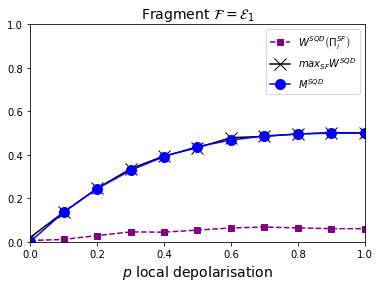

In [6]:
fig, ax = plt.subplots()

plt.title('Fragment $\\mathcal{F}=\\mathcal{E}_1$', size=14)
plt.plot(ps, Wit0_1, linestyle = 'dashed', marker = 's', color = 'purple', label = '$W^{SQD}\\left(\\Pi_i^{SF}\\right)$')
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels      
plt.xlabel("$p$ local depolarisation",size=14)

plt.ylim([0,1])
plt.xlim([0,1])

plt.plot(ps, Wit_max_1, linestyle = '-', marker = 'x', markersize = 12, color = 'black', label = '$max_{SF}W^{SQD}$')

plt.plot(ps, Ms_1, linestyle = '-', marker = 'o', markersize = 10, color='blue', label = '$M^{SQD}$')
plt.legend(loc='upper right')

# Local Depolarization, fragment $\mathcal{F}=\mathcal{E}_1\mathcal{E}_2$

The calculations for this result are nearly identical to the previous section. The only differences are that the reset gates are removed from the qubits of the second environment, an extra ancilla qubit is added to perform a parity check with the second environment and an extra if statement is added to select the measurement outcomes for a successful parity check with both environments.

In [7]:
#Creating a list of possible measurement outcomes for 8 bits
n = 8
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(7) #1 system qubit, 4 environment qubits, 2 ancilla qubits for the nondestructive parity check
cr = ClassicalRegister(n)

#Creating list of strengths of depolarizing channel
ps = np.linspace(0,1,11)

P0_2 = [] #List for probabilities of all 0s measurement on last 5 bits
Ps_2 = [] #List for probabilities of general measurement outcomes
for p in ps:
    # Error probabilities
    prob = p # 1-qubit gate

    # Depolarizing quantum errors
    error = noise.depolarizing_error(prob, 1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    qc3 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc3.h(0)
    #Creating GHZ state
    qc3.h(1)
    for i in range(1,4):
        qc3.cx(i,i+1)
    #Entangling system and environment
    qc3.cx(0,1)
    qc3.cx(0,3)
    #Adding depolarizing channel
    for j in range(5):
        qc3.id(j)
    #Mapping the states of the fragment to ancilla qubits for the nondestructive parity check
    qc3.cx(1,5)
    qc3.cx(2,5)
    qc3.cx(3,6)
    qc3.cx(4,6)
    #Measuring the system and ancilla qubits
    qc3.measure(0,0)
    qc3.measure(5,1)
    qc3.measure(6,2)
    #Adding the final unitary evolution layer
    qc3.h(0)
    qc3.h(2)
    qc3.h(4)
    #Measuring the system and fragment qubits
    for k in range(5):
        qc3.measure(k,k+3)
    
      # Perform a noise simulation
    backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, shots=Nshots)
    results3 = backend.run(qc3).result()

    counts3 = results3.get_counts()
    
    measurements = [] ##Creating a list of obtained measurement outcomes
    outcomes = [] #Obtained measurement frequencies
    for j in range(len(strings)):
        if not strings[j] in counts3: counts3[strings[j]] = 0 #Adding 0 results into the counts
        if strings[j][n-1] == strings[j][n-2]: #If loop for successful parity check
            if strings[j][n-1] == strings[j][n-3]: #Second if loop for parity check with second environment
                measurements.append(strings[j]) #Adding the obtained measurement outcome to the list
                outcomes.append(counts3[strings[j]]) #Adding the frequencies of the obtained measurement outcome to the list
    pairs = zip(measurements, outcomes) #Creating a list of pairs for measurements and their frequencies
    new_counts3 = dict(pairs) #Creating a dictionary of allowed results for the parity check
    
    P0_2.append((new_counts3['00000000'] + new_counts3['00000111'])/Nshots) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(0,len(measurements),2):
        #Calculating the probability of each measurement outcome
        Probs.append((new_counts3[measurements[k]] + new_counts3[measurements[k+1]])/Nshots)
    
    Ps_2.append(Probs) #Adding probabilities to list for each p

In [8]:
qr_id = QuantumRegister(5) #Creating new quantum register
cr_id = ClassicalRegister(5) #Creating new classical register
P0_id_2 = [] #Initialising list to stores probabilities of 0 string
Ps_id_2 = [] #Initialising list to store probability array of each measurement outcome

#Creating list of measurement outcome strings for 5 qubits
n = 5
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
for p in ps:
    # Error probabilities
    prob = p # 1-qubit gate

    # Depolarizing quantum errors
    error = noise.depolarizing_error(prob, 1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    qc4 = QuantumCircuit(qr_id,cr_id)
    #Initialising system quantum state
    qc4.h(0)
    #Creating environment GHZ state
    qc4.h(1)
    for i in range(1,4):
        qc4.cx(i,i+1)
    #Entangling system and environment
    qc4.cx(0,1)
    qc4.cx(0,3)
    #Applying depolarizing channel to qubits
    for j in range(5):
        qc4.id(j)
    #Final unitary evolution layer
    qc4.h(0)
    qc4.h(2)
    qc4.h(4)
    #Measuring system and fragment qubits
    for k in range(5):
        qc4.measure(k,k)
    
    # Perform a noise simulation
    backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, shots=Nshots)
    results4 = backend.run(qc4).result()

    counts4 = results4.get_counts()
    
    #Calculating probability of 0 string measurement
    P0_id_2.append(counts4["00000"]/Nshots)
    
    #Assigning a value to measurement outcomes which were not obtained
    for j in range(len(strings)):
        if not strings[j] in counts4: counts4[strings[j]] = 0
    
    Probs = [] #Initialising a list to store measurement probabilities in
    for k in range(len(counts4)):
        #Calculating the probability of each measurement outcome
        Probs.append(counts4[strings[k]]/Nshots)
    Ps_id_2.append(Probs) #Adding the probabilities array to the initial list

In [9]:
Wit0_2 = [] #Initialising a list to store witness values for the 0 string
for i in range(len(P0_2)):
    Wit0_2.append(np.abs(P0_2[i]-P0_id_2[i])) #Calculating the witness using the obtained 0 string probabilities
    
Wit_max_2 = [] #Initialising a list to store witness values for all measurement probabilities
for j in range(len(ps)): #Looping over the different p values
    Diff_plus = []
    Diff_minus = []
    for k in range(len(Ps_2[j])): #Looping over the measurement outcomes
        Diff = Ps_id_2[j][k] - Ps_2[j][k]
        if Diff >= 0:
            Diff_plus.append(Diff)
        else:
            Diff_minus.append(Diff)
    Wit_max_2.append(np.max([np.abs(sum(Diff_plus)),np.abs(sum(Diff_minus))])) #Adding the absolute value of the sum of probability difference to the witness list

In [10]:
dm = np.zeros((2**5, 2**5)) #Creating initial density matrix of 0s
dm[0][0] = 1 #Initialising the 0 state density matrix

rho = DensityMatrix(dm) #Changing the density matrix to the DensityMatrix class

Proj_0 = DensityMatrix(np.array([[1,0],[0,0]])) #Creating the projector onto the |0> state
Proj_1 = DensityMatrix(np.array([[0,0],[0,1]])) #Creating the projector onto the |1> state
Pi0 = DensityMatrix(np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])) #Projector onto {|00>,|11>} subspace
Pi1 = DensityMatrix(np.array([[0,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0]])) #Projector onto {|01>,|10>} subspace
Obj_0 = Pi0.tensor(Pi0).tensor(Proj_0)
Obj_1 = Pi1.tensor(Pi1).tensor(Proj_1)

Ms_2 = [] #Creating a list to store non-objectivity measure

for p in ps:
    # Error probabilities
    prob = p # 1-qubit gate

    # Depolarizing quantum errors
    error = noise.depolarizing_error(prob, 1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    #Defining quantum circuit up to application of objectivity operation
    qc_loc2 = QuantumCircuit(5)
    qc_loc2.h(0)
    qc_loc2.h(1)
    for i in range(1,4):
        qc_loc2.cx(i,i+1)
    qc_loc2.cx(0,1)
    qc_loc2.cx(0,3)
    for j in range(5):
        qc_loc2.id(j)
    qc_loc2.save_state(label='rho')
    
    backend = AerSimulator(method='density_matrix',noise_model=noise_model, basis_gates=basis_gates, shots=Nshots)
    results_loc2 = backend.run(qc_loc2).result()

    #Finding density matrix at time t
    rho_t = results_loc2.data()['rho']
    #Applying the objectivity operation to the reduced density matrix
    rho_obj = rho_t.evolve(Obj_0) + rho_t.evolve(Obj_1)
    
    A = rho_t-rho_obj #Calculating the difference between density matrices
    #Calculating the trace norm of the difference, the sum of the absolute values of the eigenvalues
    eigenvals, eigenvecs = np.linalg.eig(A)
    M = 0
    for v in eigenvals:
        M += np.abs(v)
 
    Ms_2.append(M) #Adding the non-objectivity measure to the list

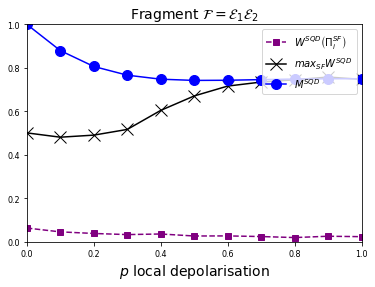

In [11]:
fig, ax = plt.subplots()

plt.title('Fragment $\\mathcal{F}=\\mathcal{E}_1\\mathcal{E}_2$', size=14)
plt.plot(ps, Wit0_2, linestyle = 'dashed', marker = 's', color = 'purple', label = '$W^{SQD}\\left(\\Pi_i^{SF}\\right)$')
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels      
plt.xlabel("$p$ local depolarisation",size=14)

plt.ylim([0,1])
plt.xlim([0,1])

plt.plot(ps, Wit_max_2, linestyle = '-', marker = 'x', markersize = 12, color = 'black', label = '$max_{SF}W^{SQD}$')

plt.plot(ps, Ms_2, linestyle = '-', marker = 'o', markersize = 10, color='blue', label = '$M^{SQD}$')
plt.legend(loc='upper right')

# Global Depolarization, fragment $\mathcal{F}=\mathcal{E}_1$

Calculations are done similarly to the first section. Instead of having the controlled-swap gates for the local depolarizing channel, for 8000 shots of the circuit, $8000(1-p)$ shots are run with the state prepared as $|\Psi(0)\rangle$ before the objectivity or identity operation and $8000p$ shots are run with the state prepared as $\frac{\mathcal{I}}{32}$.

The maximally mixed state is prepared using a control qubit in the $|1\rangle$ stateso the controlled-swap gate always activates and swaps the system and environment qubits with maximally mixed qubits.

All measurement frequencies are divided by 8000, the total number of shots between both runs, so the probabilities are added together properly.

After both circuit runs the probabilities from each run are added together to obtain the appropriate probabilities from the whole run.

In [12]:
P0_3_psi = [] #List to store results for pure state circuit run
P0_3_mix = [] #List to store results for maximally mixed state circuit run

Ps_3_psi = [] #List to store results for pure state circuit run
Ps_3_mix = [] #List to store results for maximally mixed state circuit run

In [14]:
backend_sim = AerSimulator()

ps_new = np.linspace(0,0.9,10) #Defining a new set of p values so shots is not set to 0

#Creating a list of possible measurement outcomes for 5 bits
n = 5
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(6) #1 system qubit, 4 environment qubits and 1 ancilla qubit for parity check
cr = ClassicalRegister(n)

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(1-p))

    qc5 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc5.h(0)
    #Creating GHZ state
    qc5.h(1)
    for i in range(1,4):
        qc5.cx(i,i+1)
    #Entangling system and environment
    qc5.cx(0,1)
    qc5.cx(0,3)
    #Mapping the states of the fragment to an ancilla qubit for the nondestructive parity check
    qc5.cx(1,5)
    qc5.cx(2,5)
    #Measuring the system and ancilla qubits
    qc5.measure(0,0)
    qc5.measure(5,1)
    #Resetting the non-fragment environment qubits
    qc5.reset(3)
    qc5.reset(4)
    #Adding the final unitary evolution layer
    qc5.h(0)
    qc5.h(2)
    qc5.h(4)
    #Measuring the system and fragment qubits
    for k in range(3):
        qc5.measure(k,k+2)
    
    #Running the job
    job5 = backend_sim.run(qc5, shots = Nshots)
    
    #Extracting results
    results5 = job5.result()

    #Extracting frequencies of each measurement
    counts5 = results5.get_counts()
    
    measurements = [] ##Creating a list of obtained measurement outcomes
    outcomes = [] #Obtained measurement frequencies
    for j in range(len(strings)):
        if not strings[j] in counts5: counts5[strings[j]] = 0 #Adding 0 results into the counts
        if strings[j][n-1] == strings[j][n-2]: #If loop for successful parity check
            measurements.append(strings[j]) #Adding the obtained measurement outcome to the list
            outcomes.append(counts5[strings[j]]) #Adding the frequencies of the obtained measurement outcome to the list
    pairs = zip(measurements, outcomes) #Creating a list of pairs for measurements and their frequencies
    new_counts5 = dict(pairs) #Creating a dictionary of allowed results for the parity check
    
    P0_3_psi.append((new_counts5['00000'] + new_counts5['00011'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(0,len(measurements),2):
        #Calculating the probability of each measurement outcome
        Probs.append((new_counts5[measurements[k]] + new_counts5[measurements[k+1]])/12000)
    
    Ps_3_psi.append(Probs) #Adding probabilities to list for each p

In [15]:
ps_new = np.linspace(0.1,1,10) #Defining new set of p values so shots won't be 0

#Creating a list of possible measurement outcomes for 5 bits
n = 5
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(9) #1 system qubit, 4 environment qubits, 3 ancilla qubits to create mixed state, 1 ancilla qubit for parity check
cr = ClassicalRegister(n)

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(p))

    qc5 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc5.h(0)
    #Creating GHZ state
    qc5.h(1)
    for i in range(1,4):
        qc5.cx(i,i+1)
    #Entangling system and environment
    qc5.cx(0,1)
    qc5.cx(0,3)
    #Adding ancilla qubits to implement depolarizing channels on each qubit
    #Creating Bell state so one qubit will be maximally mixed
    qc5.h(5)
    qc5.cx(5,6)
    #Creating control qubit which creates mixed state
    qc5.x(7)
    #Adding depolarizing channel gate for system qubit
    qc5.cswap(7,5,0)
    #Reseting and recreating the Bell state and implementing the depolarizing channel for the environment qubits
    for j in range(1,5):
        qc5.reset(5)
        qc5.reset(6)
        qc5.h(5)
        qc5.cx(5,6)
        qc5.cswap(7,5,j)
    #Mapping the states of the fragment to an ancilla qubit for the nondestructive parity check
    qc5.cx(1,8)
    qc5.cx(2,8)
    #Measuring the system and ancilla qubits
    qc5.measure(0,0)
    qc5.measure(8,1)
    #Reseting the non-fragment environment qubits
    qc5.reset(3)
    qc5.reset(4)
    #Adding the final evolution layer
    qc5.h(0)
    qc5.h(2)
    qc5.h(4)
    #Measuring the system and fragment qubits
    for k in range(3):
        qc5.measure(k,k+2)
    
    #Running the job
    job5 = backend_sim.run(qc5, shots = Nshots)
    
    #Extracting results
    results5 = job5.result()

    #Extracting frequencies of each measurement
    counts5 = results5.get_counts()
    
    measurements = [] ##Creating a list of obtained measurement outcomes
    outcomes = [] #Obtained measurement frequencies
    for j in range(len(strings)):
        if not strings[j] in counts5: counts5[strings[j]] = 0 #Adding 0 results into the counts
        if strings[j][n-1] == strings[j][n-2]: #If loop for successful parity check
            measurements.append(strings[j]) #Adding the obtained measurement outcome to the list
            outcomes.append(counts5[strings[j]]) #Adding the frequencies of the obtained measurement outcome to the list
    pairs = zip(measurements, outcomes) #Creating a list of pairs for measurements and their frequencies
    new_counts5 = dict(pairs) #Creating a dictionary of allowed results for the parity check
    
    P0_3_mix.append((new_counts5['00000'] + new_counts5['00011'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(0,len(measurements),2):
        #Calculating the probability of each measurement outcome
        Probs.append((new_counts5[measurements[k]] + new_counts5[measurements[k+1]])/12000)
    
    Ps_3_mix.append(Probs) #Adding probabilities to list for each p

In [16]:
P0_3 = [P0_3_psi[0]] #List for probabilities of all 0s measurement on last 3 bits
Ps_3 = [Ps_3_psi[0]] #List for probabilities of general measurement outcomes
for j in range(1,len(P0_3_psi)):
    P0_3.append(P0_3_psi[j] + P0_3_mix[j-1]) #Adding probabilities together due to shifted p values on both runs
P0_3.append(P0_3_mix[9])

for j in range(1,len(Ps_3_psi)):
    tot = []
    for k in range(len(Ps_3_psi[j])):
        tot.append(Ps_3_psi[j][k] + Ps_3_mix[j-1][k])
    Ps_3.append(tot)
Ps_3.append(Ps_3_mix[9])

In [17]:
P0_id_3_psi = [] #List to store results for pure state circuit run
P0_id_3_mix = [] #List to store results for maximally mixed state circuit run

Ps_id_3_psi = [] #List to store results for pure state circuit run
Ps_id_3_mix = [] #List to store results for maximally mixed state circuit run

In [18]:
#Creating a list of possible measurement outcomes for 3 bits
n = 3
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(5) #1 system qubit, 4 environment qubits
cr = ClassicalRegister(n)

ps_new = np.linspace(0,0.9,10) #Creating list of p values

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(1-p))

    qc6 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc6.h(0)
    #Creating GHZ state
    qc6.h(1)
    for i in range(1,4):
        qc6.cx(i,i+1)
    #Entangling system and environment
    qc6.cx(0,1)
    qc6.cx(0,3)
    #Reseting non-fragment qubits
    qc6.reset(3)
    qc6.reset(4)
    #Adding the final evolution layer
    qc6.h(0)
    qc6.h(2)
    qc6.h(4)
    #Measuring the system and fragment qubits
    for k in range(3):
        qc6.measure(k,k)
    
    #Running the job
    job6 = backend_sim.run(qc6, shots = Nshots)
    
    #Extracting results
    results6 = job6.result()

    #Extracting frequencies of each measurement
    counts6 = results6.get_counts()
    
    for j in range(len(strings)):
        if not strings[j] in counts6: counts6[strings[j]] = 0 #Adding 0 results into the counts
    
    P0_id_3_psi.append((counts6['000'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(len(counts6)):
        #Calculating the probability of each measurement outcome
        Probs.append(counts6[strings[k]]/12000)
    
    Ps_id_3_psi.append(Probs) #Adding probabilities to list for each p

In [19]:
#Creating a list of possible measurement outcomes for 3 bits
n = 3
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(8) #1 system qubit, 4 environment qubits, 3 ancilla qubits to create mixed state
cr = ClassicalRegister(n)

ps_new = np.linspace(0.1,1,10) #Creating new list of p values

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(p))

    qc6 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc6.h(0)
    #Creating GHZ state
    qc6.h(1)
    for i in range(1,4):
        qc6.cx(i,i+1)
    #Entangling system and environment
    qc6.cx(0,1)
    qc6.cx(0,3)
    #Adding depolarizing channels
    qc6.h(5)
    qc6.cx(5,6)
    qc6.x(7)
    qc6.cswap(7,5,0)
    for i in range(1,5):
        qc6.reset(5)
        qc6.reset(6)
        qc6.h(5)
        qc6.cx(5,6)
        qc6.cswap(7,5,i)
    #Reseting non-fragment qubits
    qc6.reset(3)
    qc6.reset(4)
    #Adding the final evolution layer
    qc6.h(0)
    qc6.h(2)
    qc6.h(4)
    #Measuring the system and fragment qubits
    for k in range(3):
        qc6.measure(k,k)
    
    #Running the job
    job6 = backend_sim.run(qc6, shots = Nshots)
    
    #Extracting results
    results6 = job6.result()

    #Extracting frequencies of each measurement
    counts6 = results6.get_counts()
    
    for j in range(len(strings)):
        if not strings[j] in counts6: counts6[strings[j]] = 0 #Adding 0 results into the counts
    
    P0_id_3_mix.append((counts6['000'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(len(counts6)):
        #Calculating the probability of each measurement outcome
        Probs.append(counts6[strings[k]]/12000)
    
    Ps_id_3_mix.append(Probs) #Adding probabilities to list for each p

In [20]:
P0_id_3 = [P0_id_3_psi[0]] #List for probabilities of all 0s measurement on last 3 bits
Ps_id_3 = [Ps_id_3_psi[0]] #List for probabilities of general measurement outcomes
for j in range(1,len(P0_id_3_psi)):
    P0_id_3.append(P0_id_3_psi[j] + P0_id_3_mix[j-1])
P0_id_3.append(P0_id_3_mix[9])

for j in range(1,len(Ps_id_3_psi)):
    tot = []
    for k in range(len(Ps_id_3_psi[j])):
        tot.append(Ps_id_3_psi[j][k] + Ps_id_3_mix[j-1][k])
    Ps_id_3.append(tot)
Ps_id_3.append(Ps_id_3_mix[9])

In [21]:
Wit0_3 = [] #Initialising a list to store witness values for the 0 string
for i in range(len(P0_3)):
    Wit0_3.append(np.abs(P0_3[i]-P0_id_3[i])) #Calculating the witness using the obtained 0 string probabilities
    
Wit_max_3 = [] #Initialising a list to store witness values for all measurement probabilities
for j in range(len(ps)): #Looping over the different p values
    Diff_plus = []
    Diff_minus = []
    for k in range(len(Ps_3[j])): #Looping over the measurement outcomes
        Diff = Ps_id_3[j][k] - Ps_3[j][k]
        if Diff >= 0:
            Diff_plus.append(Diff)
        else:
            Diff_minus.append(Diff)
    Wit_max_3.append(np.max([np.abs(sum(Diff_plus)),np.abs(sum(Diff_minus))])) #Adding the absolute value of the sum of probability difference to the witness list

In [22]:
dm = np.zeros((2**5, 2**5)) #Creating initial density matrix of 0s
dm[0][0] = 1 #Initialising the 0 state density matrix

rho = DensityMatrix(dm) #Changing the density matrix to the DensityMatrix class

Proj_0 = DensityMatrix(np.array([[1,0],[0,0]])) #Creating the projector onto the |0> state
Proj_1 = DensityMatrix(np.array([[0,0],[0,1]])) #Creating the projector onto the |1> state
Pi0 = DensityMatrix(np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])) #Projector onto {|00>,|11>} subspace
Pi1 = DensityMatrix(np.array([[0,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0]])) #Projector onto {|01>,|10>} subspace
Obj_0 = Pi0.tensor(Proj_0) #Objectivity operation for 0 measurement
Obj_1 = Pi1.tensor(Proj_1) #Objectivity operation for 1 measurement

#Defining quantum circuit up to application of objectivity operation for pure state
qc_mix1 = QuantumCircuit(5)
qc_mix1.h(0)
qc_mix1.h(1)
for i in range(1,4):
    qc_mix1.cx(i,i+1)
qc_mix1.cx(0,1)
qc_mix1.cx(0,3)
    
#Finding density matrix at time t
rho_psi = rho.evolve(qc_mix1)

Ms_3 = [] #Initialising list to store non-objectivity measure values
for p in ps:
    rho_t = (1-p)*rho_psi + (p/32)*Operator(np.identity(32)) #Defining mixed state using obtained pure state
    #Finding reduced density matrix for system and fragment qubits
    rho_red = partial_trace(rho_t, [3,4])
    #Applying the objectivity operation to the reduced density matrix
    rho_obj = rho_red.evolve(Obj_0) + rho_red.evolve(Obj_1)
    
    A = rho_red-rho_obj #Calculating the difference between density matrices
    #Calculating the trace norm of the difference, the sum of the absolute values of the eigenvalues
    eigenvals, eigenvecs = np.linalg.eig(A)
    M = 0
    for v in eigenvals:
        M += np.abs(v)

    Ms_3.append(M)

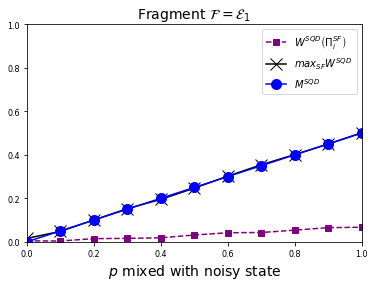

In [23]:
fig, ax = plt.subplots()

plt.title('Fragment $\\mathcal{F}=\\mathcal{E}_1$', size=14)
plt.plot(ps, Wit0_3, linestyle = 'dashed', marker = 's', color = 'purple', label = '$W^{SQD}\\left(\\Pi_i^{SF}\\right)$')
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels      
plt.xlabel("$p$ mixed with noisy state",size=14)

plt.ylim([0,1])
plt.xlim([0,1])

plt.plot(ps, Wit_max_3, linestyle = '-', marker = 'x', markersize = 12, color = 'black', label = '$max_{SF}W^{SQD}$')

plt.plot(ps, Ms_3, linestyle = '-', marker = 'o', markersize = 10, color='blue', label = '$M^{SQD}$')
plt.legend(loc='upper right')

# Global Depolarization, fragment $\mathcal{F}=\mathcal{E}_1\mathcal{E}_2$

In [24]:
P0_4_psi = [] #List to store results for pure state circuit run
P0_4_mix = [] #List to store results for maximally mixed state circuit run

Ps_4_psi = [] #List to store results for pure state circuit run
Ps_4_mix = [] #List to store results for maximally mixed state circuit run

In [25]:
ps_new = np.linspace(0,0.9,10) #Creating a new list of p values

#Creating a list of possible measurement outcomes for 8 bits
n = 8
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(7) #1 system qubit, 4 environment qubits, 2 ancilla qubits for parity check
cr = ClassicalRegister(n)

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(1-p))

    qc7 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc7.h(0)
    #Creating GHZ state
    qc7.h(1)
    for i in range(1,4):
        qc7.cx(i,i+1)
    #Entangling system and environment
    qc7.cx(0,1)
    qc7.cx(0,3)
    #Mapping the states of the fragment to ancilla qubits for the nondestructive parity check
    qc7.cx(1,5)
    qc7.cx(2,5)
    qc7.cx(3,6)
    qc7.cx(4,6)
    #Measuring the system and ancilla qubits
    qc7.measure(0,0)
    qc7.measure(5,1)
    qc7.measure(6,2)
    #Adding the final evolution layer
    qc7.h(0)
    qc7.h(2)
    qc7.h(4)
    #Measuring the system and fragment qubits
    for k in range(5):
        qc7.measure(k,k+3)
    
    #Running the job
    job7 = backend_sim.run(qc7, shots = Nshots)
    
    #Extracting results
    results7 = job7.result()

    #Extracting frequencies of each measurement
    counts7 = results7.get_counts()
    
    measurements = [] ##Creating a list of obtained measurement outcomes
    outcomes = [] #Obtained measurement frequencies
    for j in range(len(strings)):
        if not strings[j] in counts7: counts7[strings[j]] = 0 #Adding 0 results into the counts
        if strings[j][n-1] == strings[j][n-2]: #If loop for successful parity check
            if strings[j][n-1] == strings[j][n-3]: #Second if loop for parity check with second environment
                measurements.append(strings[j]) #Adding the obtained measurement outcome to the list
                outcomes.append(counts7[strings[j]]) #Adding the frequencies of the obtained measurement outcome to the list
    pairs = zip(measurements, outcomes) #Creating a list of pairs for measurements and their frequencies
    new_counts7 = dict(pairs) #Creating a dictionary of allowed results for the parity check
    
    P0_4_psi.append((new_counts7['00000000'] + new_counts7['00000111'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(0,len(measurements),2):
        #Calculating the probability of each measurement outcome
        Probs.append((new_counts7[measurements[k]] + new_counts7[measurements[k+1]])/12000)
    
    Ps_4_psi.append(Probs) #Adding probabilities to list for each p

In [26]:
ps_new = np.linspace(0.1,1,10) #Creating new list of p values

#Creating a list of possible measurement outcomes for 8 bits
n = 8
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(10) #1 system qubit. 4 environment qubits, 3 ancilla qubits to create mixed state, 2 ancilla parity check qubits
cr = ClassicalRegister(n)

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(p))

    qc7 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc7.h(0)
    #Creating GHZ state
    qc7.h(1)
    for i in range(1,4):
        qc7.cx(i,i+1)
    #Entangling system and environment
    qc7.cx(0,1)
    qc7.cx(0,3)
    #Creating maximally mixed state
    qc7.h(5)
    qc7.cx(5,6)
    qc7.x(7)
    qc7.cswap(7,5,0)
    for i in range(1,5):
        qc7.reset(5)
        qc7.reset(6)
        qc7.h(5)
        qc7.cx(5,6)
        qc7.cswap(7,5,i)
    #Mapping the states of the fragment to an ancilla qubit for the nondestructive parity check
    qc7.cx(1,8)
    qc7.cx(2,8)
    qc7.cx(3,9)
    qc7.cx(4,9)
    #Measuring the system and ancilla qubits
    qc7.measure(0,0)
    qc7.measure(8,1)
    qc7.measure(9,2)
    #Adding the final evolution layer
    qc7.h(0)
    qc7.h(2)
    qc7.h(4)
    #Measuring the system and fragment qubits
    for k in range(5):
        qc7.measure(k,k+3)
    
    #Running the job
    job7 = backend_sim.run(qc7, shots = Nshots)
    
    #Extracting results
    results7 = job7.result()

    #Extracting frequencies of each measurement
    counts7 = results7.get_counts()
    
    measurements = [] ##Creating a list of obtained measurement outcomes
    outcomes = [] #Obtained measurement frequencies
    for j in range(len(strings)):
        if not strings[j] in counts7: counts7[strings[j]] = 0 #Adding 0 results into the counts
        if strings[j][n-1] == strings[j][n-2]: #If loop for successful parity check
            if strings[j][n-1] == strings[j][n-3]: #Second if loop for second parity check
                measurements.append(strings[j]) #Adding the obtained measurement outcome to the list
                outcomes.append(counts7[strings[j]]) #Adding the frequencies of the obtained measurement outcome to the list
    pairs = zip(measurements, outcomes) #Creating a list of pairs for measurements and their frequencies
    new_counts7 = dict(pairs) #Creating a dictionary of allowed results for the parity check
    
    P0_4_mix.append((new_counts7['00000000'] + new_counts7['00000111'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(0,len(measurements),2):
        #Calculating the probability of each measurement outcome
        Probs.append((new_counts7[measurements[k]] + new_counts7[measurements[k+1]])/12000)
    
    Ps_4_mix.append(Probs) #Adding probabilities to list for each p

In [27]:
P0_4 = [P0_4_psi[0]] #List for probabilities of all 0s measurement on 5 bits
Ps_4 = [Ps_4_psi[0]] #List for probabilities of general measurement outcomes
for j in range(1,len(P0_4_psi)):
    P0_4.append(P0_4_psi[j] + P0_4_mix[j-1])
P0_4.append(P0_4_mix[9])

for j in range(1,len(Ps_4_psi)):
    tot = []
    for k in range(len(Ps_4_psi[j])):
        tot.append(Ps_4_psi[j][k] + Ps_4_mix[j-1][k])
    Ps_4.append(tot)
Ps_4.append(Ps_4_mix[9])

In [28]:
P0_id_4_psi = [] #List to store results for pure state circuit run
P0_id_4_mix = [] #List to store results for maximally mixed state circuit run

Ps_id_4_psi = [] #List to store results for pure state circuit run
Ps_id_4_mix = [] #List to store results for maximally mixed state circuit run

In [29]:
#Creating a list of possible measurement outcomes for 5 bits
n = 5
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(5) #1 system qubit and 4 environment qubits
cr = ClassicalRegister(n)

ps_new = np.linspace(0,0.9,10) #Creating list of p values so shots won't be 0

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(1-p))

    qc8 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc8.h(0)
    #Creating GHZ state
    qc8.h(1)
    for i in range(1,4):
        qc8.cx(i,i+1)
    #Entangling system and environment
    qc8.cx(0,1)
    qc8.cx(0,3)
    #Adding the final evolution layer
    qc8.h(0)
    qc8.h(2)
    qc8.h(4)
    #Measuring the system and fragment qubits
    for k in range(5):
        qc8.measure(k,k)
    
    #Running the job
    job8 = backend_sim.run(qc8, shots = Nshots)
    
    #Extracting results
    results8 = job8.result()

    #Extracting frequencies of each measurement
    counts8 = results8.get_counts()
    
    for j in range(len(strings)):
        if not strings[j] in counts8: counts8[strings[j]] = 0 #Adding 0 results into the counts
    
    P0_id_4_psi.append((counts8['00000'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(len(counts8)):
        #Calculating the probability of each measurement outcome
        Probs.append(counts8[strings[k]]/12000)
    
    Ps_id_4_psi.append(Probs) #Adding probabilities to list for each p

In [30]:
#Creating a list of possible measurement outcomes for 5 bits
n = 5
strings = []
for i in range(2**n):
    b = bin(i)[2:]
    l = len(b)
    b = str(0) * (2*n - l - n) + b
    strings.append(b)
    
#Circuit set up
qr = QuantumRegister(8) #1 system qubit, 4 environment qubits, 3 ancilla qubits to create mixed state
cr = ClassicalRegister(n)

ps_new = np.linspace(0.1,1,10) #Creating new list of p values so shots won't be 0

for p in ps_new:
    #Setting the number of shots
    Nshots = int(12000*(p))

    qc8 = QuantumCircuit(qr,cr)
    #Initialise system qubit
    qc8.h(0)
    #Creating GHZ state
    qc8.h(1)
    for i in range(1,4):
        qc8.cx(i,i+1)
    #Entangling system and environment
    qc8.cx(0,1)
    qc8.cx(0,3)
    #Adding depolarizing channels
    qc8.h(5)
    qc8.cx(5,6)
    qc8.x(7)
    qc8.cswap(7,5,0)
    for i in range(1,5):
        qc8.reset(5)
        qc8.reset(6)
        qc8.h(5)
        qc8.cx(5,6)
        qc8.cswap(7,5,i)
    #Adding the final evolution layer
    qc8.h(0)
    qc8.h(2)
    qc8.h(4)
    #Measuring the system and fragment qubits
    for k in range(5):
        qc8.measure(k,k)
    
    #Running the job
    job8 = backend_sim.run(qc8, shots = Nshots)
    
    #Extracting results
    results8 = job8.result()

    #Extracting frequencies of each measurement
    counts8 = results8.get_counts()
    
    for j in range(len(strings)):
        if not strings[j] in counts8: counts8[strings[j]] = 0 #Adding 0 results into the counts
    
    P0_id_4_mix.append((counts8['00000'])/12000) #Calculating probability of 0 string measurement
    Probs = [] #Initialising list of probabilities of each measurement outcome
    for k in range(len(counts8)):
        #Calculating the probability of each measurement outcome
        Probs.append(counts8[strings[k]]/12000)
    
    Ps_id_4_mix.append(Probs) #Adding probabilities to list for each p

In [31]:
P0_id_4 = [P0_id_4_psi[0]] #List for probabilities of all 0s measurement on last 5 bits
Ps_id_4 = [Ps_id_4_psi[0]] #List for probabilities of general measurement outcomes
for j in range(1,len(P0_id_4_psi)):
    P0_id_4.append(P0_id_4_psi[j] + P0_id_4_mix[j-1])
P0_id_4.append(P0_id_4_mix[9])

for j in range(1,len(Ps_id_4_psi)):
    tot = []
    for k in range(len(Ps_id_4_psi[j])):
        tot.append(Ps_id_4_psi[j][k] + Ps_id_4_mix[j-1][k])
    Ps_id_4.append(tot)
Ps_id_4.append(Ps_id_4_mix[9])

In [32]:
Wit0_4 = [] #Initialising a list to store witness values for the 0 string
for i in range(len(P0_4)):
    Wit0_4.append(np.abs(P0_4[i]-P0_id_4[i])) #Calculating the witness using the obtained 0 string probabilities
    
Wit_max_4 = [] #Initialising a list to store witness values for all measurement probabilities
for j in range(len(ps)): #Looping over the different p values
    Diff_plus = []
    Diff_minus = []
    for k in range(len(Ps_4[j])): #Looping over the measurement outcomes
        Diff = Ps_id_4[j][k] - Ps_4[j][k]
        if Diff >= 0:
            Diff_plus.append(Diff)
        else:
            Diff_minus.append(Diff)
    Wit_max_4.append(np.max([np.abs(sum(Diff_plus)),np.abs(sum(Diff_minus))])) #Adding the absolute value of the sum of probability difference to the witness list

In [33]:
dm = np.zeros((2**5, 2**5)) #Creating initial density matrix of 0s
dm[0][0] = 1 #Initialising the 0 state density matrix

rho = DensityMatrix(dm) #Changing the density matrix to the DensityMatrix class

Proj_0 = DensityMatrix(np.array([[1,0],[0,0]])) #Creating the projector onto the |0> state
Proj_1 = DensityMatrix(np.array([[0,0],[0,1]])) #Creating the projector onto the |1> state
Pi0 = DensityMatrix(np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])) #Projector onto {|00>,|11>} subspace
Pi1 = DensityMatrix(np.array([[0,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,0]])) #Projector onto {|01>,|10>} subspace
Obj_0 = Pi0.tensor(Pi0).tensor(Proj_0) #Objectivity operation for 0 measurement
Obj_1 = Pi1.tensor(Pi1).tensor(Proj_1) #Objectivity operation for 1 measurement

#Defining quantum circuit up to application of objectivity operation
qc_mix2 = QuantumCircuit(5)
qc_mix2.h(0)
qc_mix2.h(1)
for i in range(1,4):
    qc_mix2.cx(i,i+1)
qc_mix2.cx(0,1)
qc_mix2.cx(0,3)
    
#Finding density matrix at time t
rho_psi = rho.evolve(qc_mix2)

Ms_4 = [] #Creating list to store non-objectivity measure values
for p in ps:
    rho_t = (1-p)*rho_psi + (p/32)*Operator(np.identity(32)) #Defining mixed state density matrix
    #Applying the objectivity operation to the total density matrix
    rho_obj = rho_t.evolve(Obj_0) + rho_t.evolve(Obj_1)
    
    A = rho_t-rho_obj #Calculating the difference between density matrices
    #Calculating the trace norm of the difference, the sum of the absolute values of the eigenvalues
    eigenvals, eigenvecs = np.linalg.eig(A)
    M = 0
    for v in eigenvals:
        M += np.abs(v)

    Ms_4.append(M)

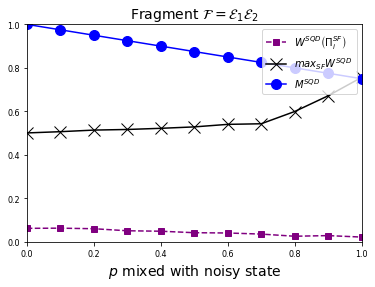

In [34]:
fig, ax = plt.subplots()

plt.title('Fragment $\\mathcal{F}=\\mathcal{E}_1\\mathcal{E}_2$', size=14)
plt.plot(ps, Wit0_4, linestyle = 'dashed', marker = 's', color = 'purple', label = '$W^{SQD}\\left(\\Pi_i^{SF}\\right)$')
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels      
plt.xlabel("$p$ mixed with noisy state",size=14)

plt.ylim([0,1])
plt.xlim([0,1])

plt.plot(ps, Wit_max_4, linestyle = '-', marker = 'x', markersize = 12, color = 'black', label = '$max_{SF}W^{SQD}$')

plt.plot(ps, Ms_4, linestyle = '-', marker = 'o', markersize = 10, color='blue', label = '$M^{SQD}$')
plt.legend(loc='upper right')